In [1]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

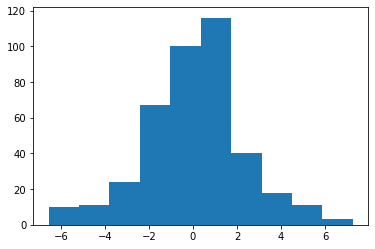

In [2]:
N = 40
T = 10

rank = 5

U_true = np.random.randn(N, rank)
V_true = np.random.randn(T, rank)

R_true = U_true @ V_true.T + 0.01 * np.random.randn(N, T)

plt.hist(R_true.flatten())

C = 4 * np.ones(T)

In [3]:
def solving_system(R, C, reg=1e-5):
    N, T = R.shape
    A1 = np.zeros((N, N * T))
    for i in range(N):
        A1[i, i * T:(i + 1) * T] = np.ones((T))

    A2 = np.zeros((T, N * T))
    for i in range(T):
        A2[i, i:N * T:T] = np.ones((N))
      
    A = np.concatenate((A1, A2, -1 * np.identity(N * T)))
    
    c = -1 * R.reshape((N * T, 1))

    b = np.concatenate((np.ones(N), C, np.zeros(N * T)))
      
    P = reg * np.identity(N * T)
    solvers.options['show_progress'] = False
    sol = solvers.qp(matrix(P, tc='d'), matrix(c, tc='d'), matrix(A, tc='d'), matrix(b, tc='d'))
    x_sys = np.array(sol['x']).reshape((N, T))
    q_sys = np.array(sol['z'])
    return x_sys, q_sys

In [4]:
x, q = solving_system(R_true, C)

4
114.79931549780981


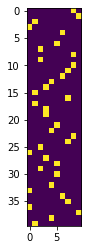

In [5]:
x = np.int32(x > 0.5)
plt.imshow(x)
print(np.max(np.sum(x, axis=0)))
print(np.sum(x * R_true))

10.0
130.7094987989396


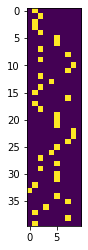

In [6]:
max_ind = np.argmax(R_true, axis=1)
x_without_C = np.zeros((N, T))
x_without_C[np.arange(N), max_ind] = 1
plt.imshow(x_without_C)
print(np.max(np.sum(x_without_C, axis=0)))
print(np.sum(x_without_C * R_true))

In [7]:
sigma = 1
sigma_u = 1
sigma_v = 1
k = 5

def update_UV(observations, U, V, Sigma_U, Sigma_V):

    iter = 0
    
    while True:
        U_prev = U.copy()
        for i in range(N):
            Sigma_sum = 0
            mean_sum = 0
            for obs in observations:
                if obs[0] == i:
                    Sigma_sum += Sigma_V[obs[1]] + np.outer(V[obs[1]], V[obs[1]])
                    mean_sum += obs[2] * V[obs[1]]
            Sigma_U[i] = np.linalg.inv(1/sigma**2 * Sigma_sum + 1/sigma_u**2 * np.identity(k))
            U[i] = Sigma_U[i] @ mean_sum / sigma**2

        for j in range(T):
            Sigma_sum = 0
            mean_sum = 0
            for obs in observations:
                if obs[1] == j:
                    Sigma_sum += Sigma_U[obs[0]] + np.outer(U[obs[0]], U[obs[0]])
                    mean_sum += obs[2] * U[obs[0]]
            Sigma_V[j] = np.linalg.inv(1/sigma**2 * Sigma_sum + 1/sigma_v**2 * np.identity(k))
            V[j] = Sigma_V[j] @ mean_sum / sigma**2
        
        iter += 1
        if np.linalg.norm(U - U_prev) < 1e-2 or iter > 100:
            break
    
    return U, V, Sigma_U, Sigma_V

In [14]:
is_mask_feasible = False
while not is_mask_feasible:
    initial_mask = np.zeros((N, T))
    for i in range(N):
        j = np.random.choice(T)
        initial_mask[i, j] = 1

    if np.min(np.sum(initial_mask, axis=0)) > 0:
        is_mask_feasible = True
        
observations = []
for i in range(N):
    for j in range(T):
        if initial_mask[i, j] == 1:
            observations.append((i, j, R_true[i, j] + np.random.randn()))

In [15]:
Sigma_U = np.stack([np.identity(k) for _ in range(N)], axis=0)
Sigma_V = np.stack([np.identity(k) for _ in range(T)], axis=0)
U = np.random.randn(N, k)
V = np.random.randn(T, k)

In [16]:
horizon = 100

history = np.zeros(horizon)

for t in range(horizon):

    U, V, Sigma_U, Sigma_V = update_UV(observations, U, V, Sigma_U, Sigma_V)
    R_UCB = np.zeros((N,T))

    for i in range(N):
        for j in range(T):
            R_UCB[i,j] = U[i] @ V[j] + 2 * np.sqrt(np.trace(Sigma_U[i].T @ Sigma_V[j] + Sigma_U[i].T @ np.outer(V[j], V[j]) + np.outer(U[i], U[i]) @ Sigma_V[j]))

    x_UCB, _ = solving_system(R_UCB, C)
    x_UCB = np.int32(x_UCB > 0.5)

#     plt.imshow(x_UCB)
#     plt.show()
    print(np.max(np.sum(x_UCB, axis=0)))
    print(np.sum(x_UCB, axis=0))
    print(np.sum(x_UCB * R_true))
    
    history[t] = np.sum(x_UCB * R_true)

    for i in range(N):
        for j in range(T):
            if x_UCB[i, j] == 1:
                observations.append((i, j, R_true[i, j]))

4
[4 4 4 4 4 4 4 4 4 4]
26.03766233625797
4
[4 4 4 4 4 4 4 4 4 4]
19.99882256812686
4
[4 4 4 4 4 4 4 4 4 4]
67.75842883884357
4
[4 4 4 4 4 4 4 4 4 4]
65.25170767904953
4
[4 4 4 4 4 4 4 4 4 4]
74.98568410766342
4
[4 4 4 4 4 4 4 4 4 4]
97.74073778559003
4
[4 4 4 4 4 4 4 4 4 4]
98.47519762380736
4
[4 4 4 4 4 4 4 4 4 4]
108.65769449350394
4
[4 4 4 4 4 4 4 4 4 4]
107.9126220334914
4
[4 4 4 4 4 4 4 4 4 4]
109.76057925368666
4
[4 4 4 4 4 4 4 4 4 4]
106.85472023266612
4
[4 4 4 4 4 4 4 4 4 4]
102.08445615475506
4
[4 4 4 4 4 4 4 4 4 4]
100.52127889479095
4
[4 4 4 4 4 4 4 4 4 4]
104.79595023414673
4
[4 4 4 4 4 4 4 4 4 4]
107.57391110697593
4
[4 4 4 4 4 4 4 4 4 4]
109.82080909059573
4
[4 4 4 4 4 4 4 4 4 4]
107.17785411782432
4
[4 4 4 4 4 4 4 4 4 4]
110.73254747767291
4
[4 4 4 4 4 4 4 4 4 4]
107.50056190604366
4
[4 4 4 4 4 4 4 4 4 4]
111.35760038569605
4
[4 4 4 4 4 4 4 4 4 4]
110.67435309139265
4
[4 4 4 4 4 4 4 4 4 4]
110.70621051160761
4
[4 4 4 4 4 4 4 4 4 4]
111.93358094802353
4
[4 4 4 4 4 4 4 4 

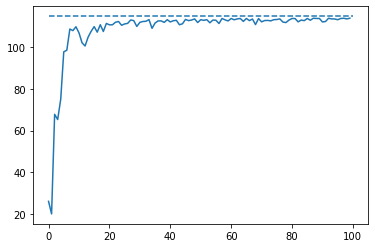

In [17]:
plt.plot(history)
plt.hlines(np.sum(x * R_true), 0, horizon, linestyles='dashed')

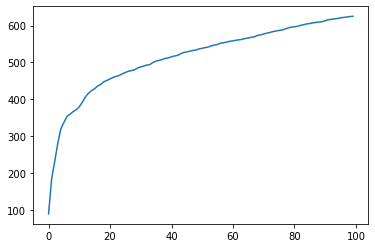

In [18]:
plt.plot(np.arange(horizon), np.cumsum(np.sum(x * R_true) - history))